In [1]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 333 kB/s 


In [2]:
import os 
import pandas as pd
import numpy as np
import keras
import tensorflow as tf

In [3]:
os.chdir('/content/drive/MyDrive/Gcash/MultiInput')

In [4]:
data = pd.read_csv('merged_movies.csv')

In [5]:
# use this data with keywords
movie_keywords= pd.read_csv('movie_models_with_keywords.csv')
data = data.merge(movie_keywords[['tconst','keywords_extract']], how = 'left', on = 'tconst')

## Preprocessing

In [6]:
data = data.drop_duplicates(subset ='tconst')

cols = ['runtimeMinutes', 'averageRating','numVotes','weighted_rating', 'runtime','vote_average','vote_count', # important features
        'genres_x', 'genres_y', 'adjusted_budget', 'adjusted_revenue', 'release_month', # possible predictive features
        'has_well_known_director','has_well_known_actors', 'is_top_production_company', # binary extracted features
        'production_countries','belongs_to_collection','has_tag_line','homepage','spoken_languages','original_english',
        'popularity','keywords','keywords_extract','directors_name','primary_actors' # for text
        ]
movie_models = data[cols]

# for now select those with at least 5k votes
movie_models = movie_models[movie_models['numVotes'] > 5000]

remove_for_now_cols = ['runtime','vote_average','vote_count','genres_y','adjusted_revenue','popularity']
model_cols = [col for col in movie_models.columns if col not in remove_for_now_cols]
movie_models = movie_models[model_cols]

# same size as basic data
movie_models = movie_models[movie_models['adjusted_budget'].notnull()]

# binary weighted rating for now
movie_models['weighted_rating'] = (movie_models['weighted_rating'] > 7).astype(int)

In [7]:
movie_models.head()

,runtimeMinutes,averageRating,numVotes,weighted_rating,genres_x,adjusted_budget,release_month,has_well_known_director,has_well_known_actors,is_top_production_company,production_countries,belongs_to_collection,has_tag_line,homepage,spoken_languages,original_english,keywords,keywords_extract,directors_name,primary_actors
21,195.0,6.2,24191.0,0,"Drama,History,War",2.486208e+06,2.0,0,0,0,1,0,1,0,1,1,[],"['history film', 'film 1915', 'birth nation']",D.W. Griffith,"Lillian Gish,Mae Marsh,Henry B. Walthall"
33,163.0,7.7,15204.0,0,"Drama,History",1.933927e+08,9.0,0,0,0,1,0,1,0,1,1,[],"['tales intolerance', 'intolerance history', '...",D.W. Griffith,"Lillian Gish,Robert Harron,Mae Marsh"
52,90.0,7.3,10122.0,0,"Drama,Romance",0.000000e+00,5.0,0,0,0,1,0,0,0,1,1,[],NaN,D.W. Griffith,"Lillian Gish,Richard Barthelmess,Donald Crisp"
62,76.0,8.1,61683.0,1,"Horror,Mystery,Thriller",2.259963e+05,2.0,0,0,0,1,0,1,0,1,0,[],"['dr caligari', 'caligari eerie', 'caligari']",Robert Wiene,"Werner Krauss,Conrad Veidt,Friedrich Feher"
68,69.0,7.0,5294.0,0,"Drama,Horror,Sci-Fi",0.000000e+00,3.0,0,0,0,1,0,1,0,1,1,[],NaN,John S. Robertson,"John Barrymore,Martha Mansfield,Brandon Hurst"


In [8]:
# convert to text month
import calendar

movie_models['release_month'] = movie_models.release_month.apply(lambda x: calendar.month_name[int(x)])

In [9]:
movie_models.dtypes

runtimeMinutes               float64
averageRating                float64
numVotes                     float64
weighted_rating                int64
genres_x                      object
adjusted_budget              float64
release_month                 object
has_well_known_director        int64
has_well_known_actors          int64
is_top_production_company      int64
production_countries           int64
belongs_to_collection          int64
has_tag_line                   int64
homepage                       int64
spoken_languages               int64
original_english               int64
keywords                      object
keywords_extract              object
directors_name                object
primary_actors                object
dtype: object

In [10]:
num_cols = ['runtimeMinutes','adjusted_budget','production_countries','spoken_languages']
cat_cols1 = ['genres_x','release_month']
cat_cols2 = ['has_well_known_director','has_well_known_actors','is_top_production_company',
            'belongs_to_collection','has_tag_line','homepage','original_english']
cat_cols3 = ['keywords','keywords_extract','directors_name','primary_actors']

movie_models[cat_cols2] = movie_models[cat_cols2].astype(object)

In [11]:
movie_models.dtypes.sort_values()

weighted_rating                int64
spoken_languages               int64
production_countries           int64
runtimeMinutes               float64
averageRating                float64
numVotes                     float64
adjusted_budget              float64
keywords_extract              object
keywords                      object
original_english              object
homepage                      object
has_tag_line                  object
is_top_production_company     object
directors_name                object
has_well_known_actors         object
has_well_known_director       object
release_month                 object
genres_x                      object
belongs_to_collection         object
primary_actors                object
dtype: object

In [12]:
movie_models = movie_models[movie_models['adjusted_budget'] > 0]

In [13]:
movie_models.shape

(6189, 20)

#### Clean text features

In [14]:
# fill missing with space
movie_models[['directors_name','primary_actors']] = movie_models[['directors_name','primary_actors']].fillna('')

In [15]:
import ast
def separate_keywords(keywords_list):
    keywords = ast.literal_eval(keywords_list)
    return ' '.join(keywords)

movie_models['keywords'] = movie_models['keywords_extract'].apply(separate_keywords)
movie_models['keywords_extract'] = movie_models['keywords_extract'].apply(separate_keywords)
movie_models[['directors_name','primary_actors']] = movie_models[['directors_name','primary_actors']].applymap(lambda x: x.replace(',', ' '))
movie_models['text_feature'] =  movie_models[['keywords','directors_name','primary_actors','keywords_extract']].apply(lambda row: ' '.join(row.values.astype(str)), axis = 1)

In [16]:
movie_models.drop(columns = ['keywords','keywords_extract','directors_name','primary_actors'], inplace = True)

In [17]:
y = ['weighted_rating']
cols_A = ['runtimeMinutes', 'genres_x','adjusted_budget','release_month', 'has_well_known_director',
          'has_well_known_actors',	'is_top_production_company',	'production_countries',
          'belongs_to_collection', 'has_tag_line', 'homepage', 'spoken_languages', 'original_english']
cols_B = ['text_feature']

In [18]:
movie_models.shape

(6189, 17)

In [19]:
# get genre dummies and add
genres_dummy =  movie_models['genres_x'].str.get_dummies(',')
movie_models = pd.concat([movie_models, genres_dummy], axis = 1)
movie_models.drop(columns = ['genres_x'], inplace = True)

In [20]:
# log of budget
movie_models['adjusted_budget'] = np.log(movie_models['adjusted_budget'])

In [21]:
movie_models.drop(columns = ['averageRating','numVotes'], inplace = True)

#### Split train set and test set

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movie_models.drop(columns=['weighted_rating'], axis = 1), movie_models['weighted_rating'], 
                                        stratify= movie_models['weighted_rating'], test_size=.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4641, 36)
(1548, 36)
(4641,)
(1548,)


In [23]:
X_train_A = X_train[num_cols + ['release_month'] + cat_cols2 + list(genres_dummy.columns)]
X_train_B = X_train['text_feature']
X_test_A = X_test[num_cols + ['release_month'] + cat_cols2 + list(genres_dummy.columns)]
X_test_B = X_test['text_feature']

In [24]:
print(X_train_A.shape)
print(X_test_A.shape)
print(X_train_A.columns)

print(X_train_B.shape)
print(X_test_B.shape)

print(y_train.mean())
print(y_test.mean())

(4641, 35)
(1548, 35)
Index(['runtimeMinutes', 'adjusted_budget', 'production_countries',
       'spoken_languages', 'release_month', 'has_well_known_director',
       'has_well_known_actors', 'is_top_production_company',
       'belongs_to_collection', 'has_tag_line', 'homepage', 'original_english',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')
(4641,)
(1548,)
0.23249299719887956
0.23255813953488372


### Model A: basic data

#### Preprocess

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_A[num_cols] = scaler.fit_transform(X_train_A[num_cols])
X_test_A[num_cols] =  scaler.transform(X_test_A[num_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [26]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols =  ['release_month'] +  cat_cols2 + list(genres_dummy.columns))
X_train_A = encoder.fit_transform(X_train_A, y_train)
X_test_A = encoder.transform(X_test_A)

# X_train_trans = X_train
# X_test_trans = X_test

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Modeling

In [27]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Input(shape = X_train_A.shape[1:]))
model_A.add(keras.layers.BatchNormalization())

for _ in range(10):
    model_A.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_A.add(keras.layers.BatchNormalization())
    model_A.add(keras.layers.Activation("elu"))
model_A.add(keras.layers.Dense(1, activation="sigmoid"))


In [45]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
model_A.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=[f1_m])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model_A.h5", save_best_only=True)
run_index = 4 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "model_A_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [46]:
history = model_A.fit(X_train_A, y_train, validation_split=0.20, epochs=500, callbacks = callbacks)

Epoch 1/500
116/116 [==============================] - 10s 17ms/step - loss: 0.7673 - f1_m: 0.3451 - val_loss: 0.6119 - val_f1_m: 0.4353
Epoch 2/500
116/116 [==============================] - 2s 13ms/step - loss: 0.6981 - f1_m: 0.3714 - val_loss: 0.5546 - val_f1_m: 0.4462
Epoch 3/500
116/116 [==============================] - 1s 12ms/step - loss: 0.6627 - f1_m: 0.4123 - val_loss: 0.5457 - val_f1_m: 0.4591
Epoch 4/500
116/116 [==============================] - 1s 10ms/step - loss: 0.6370 - f1_m: 0.4353 - val_loss: 0.5566 - val_f1_m: 0.4409
Epoch 5/500
116/116 [==============================] - 1s 10ms/step - loss: 0.6289 - f1_m: 0.4437 - val_loss: 0.5805 - val_f1_m: 0.4282
Epoch 6/500
116/116 [==============================] - 1s 11ms/step - loss: 0.6133 - f1_m: 0.4532 - val_loss: 0.5940 - val_f1_m: 0.4427
Epoch 7/500
116/116 [==============================] - 1s 10ms/step - loss: 0.6032 - f1_m: 0.4511 - val_loss: 0.5963 - val_f1_m: 0.4264
Epoch 8/500
116/116 [==========================

In [47]:
dependencies = {
    'f1_m': f1_m
}

model_A = keras.models.load_model("model_A.h5", custom_objects=dependencies)
model_A.evaluate(X_test_A, y_test)

49/49 [==============================] - 1s 3ms/step - loss: 0.4511 - f1_m: 0.4554


[0.45109492540359497, 0.4553968906402588]

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1188
           1       0.61      0.37      0.46       360

    accuracy                           0.80      1548
   macro avg       0.72      0.65      0.67      1548
weighted avg       0.78      0.80      0.78      1548

Logloss 6.939035804004385
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

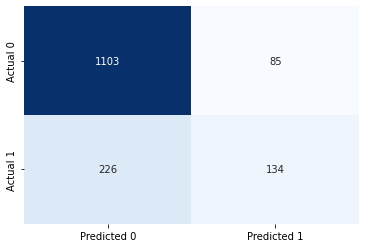

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss 
import seaborn as sns 

y_pred = model_A.predict(X_test_A)
y_pred = (y_pred >= .5).astype(int)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])

### Model B

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = .5, analyzer = 'word', stop_words = 'english', ngram_range = (1,2))
tfidf_vectorizer.fit(X_train_B)
X_train_B = tfidf_vectorizer.transform(X_train_B)
X_test_B = tfidf_vectorizer.transform(X_test_B)

In [50]:
print(X_test_B.shape)
print(X_train_B.shape)

(1548, 66393)
(4641, 66393)


In [51]:
X_train_B = X_train_B.toarray()
X_test_B = X_test_B.toarray()

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model_B = keras.models.Sequential()
model_B.add(keras.layers.Input(shape = X_train_B.shape[1:]))
model_B.add(keras.layers.BatchNormalization())

for _ in range(5):
    model_B.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_B.add(keras.layers.BatchNormalization())
    model_B.add(keras.layers.Activation("elu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))


In [58]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
model_B.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=[f1_m])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model_B.h5", save_best_only=True)
run_index = 2 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "model_B_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model_B.fit(X_train_B, y_train, validation_split=0.25, epochs=100, callbacks = callbacks)

Epoch 1/100
109/109 [==============================] - 26s 196ms/step - loss: 0.8295 - f1_m: 0.3267 - val_loss: 0.7044 - val_f1_m: 0.3531
Epoch 2/100
109/109 [==============================] - 20s 185ms/step - loss: 0.6725 - f1_m: 0.4606 - val_loss: 0.7166 - val_f1_m: 0.3541
Epoch 3/100
109/109 [==============================] - 20s 188ms/step - loss: 0.5462 - f1_m: 0.6054 - val_loss: 0.7254 - val_f1_m: 0.3595
Epoch 4/100
109/109 [==============================] - 20s 183ms/step - loss: 0.4509 - f1_m: 0.7256 - val_loss: 0.7534 - val_f1_m: 0.3591
Epoch 5/100
109/109 [==============================] - 21s 189ms/step - loss: 0.3753 - f1_m: 0.8145 - val_loss: 0.8066 - val_f1_m: 0.3519
Epoch 6/100
109/109 [==============================] - 20s 186ms/step - loss: 0.3133 - f1_m: 0.8735 - val_loss: 0.8717 - val_f1_m: 0.3414
Epoch 7/100
109/109 [==============================] - 21s 189ms/step - loss: 0.2626 - f1_m: 0.9279 - val_loss: 0.9402 - val_f1_m: 0.3449
Epoch 8/100
109/109 [=============

In [59]:
model_B = keras.models.load_model("model_B.h5", custom_objects=dependencies)
model_B.evaluate(X_test_B, y_test)

49/49 [==============================] - 2s 25ms/step - loss: 0.7047 - f1_m: 0.3567


[0.7047050595283508, 0.3567240536212921]

              precision    recall  f1-score   support

           0       0.77      0.16      0.27      1188
           1       0.23      0.83      0.36       360

    accuracy                           0.32      1548
   macro avg       0.50      0.50      0.32      1548
weighted avg       0.64      0.32      0.29      1548

Logloss 23.47260075458449
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

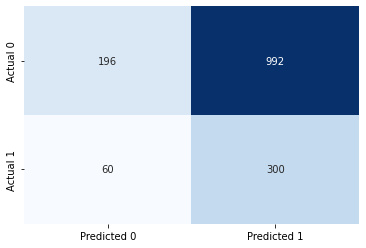

In [61]:
y_pred = model_B.predict(X_test_B)
y_pred = (y_pred >= .5).astype(int)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])

Similar f1 score with logistic regression

#### Combine models

In [ ]:
from keras.layers import *
from keras.models import Model


keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model_B = keras.models.Sequential()
model_B.add(keras.layers.Input(shape = X_train_B.shape[1:]))
model_B.add(keras.layers.BatchNormalization())

for _ in range(10):
    model_B.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_B.add(keras.layers.BatchNormalization())
    model_B.add(keras.layers.Activation("elu"))



model_A = keras.models.Sequential()
model_A.add(keras.layers.Input(shape = X_train_A.shape[1:]))
model_A.add(keras.layers.BatchNormalization())

for _ in range(5):
    model_A.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model_A.add(keras.layers.BatchNormalization())
    model_A.add(keras.layers.Activation("elu"))




mergedOut = Add()([model_A.output,model_B.output])
mergedOut = Flatten()(mergedOut) 
# output layer
mergedOut = Dense(1, activation='sigmoid')(mergedOut)

newModel = Model([model_A.input,model_B.input], mergedOut)
    #use lists if you want more than one input or output  



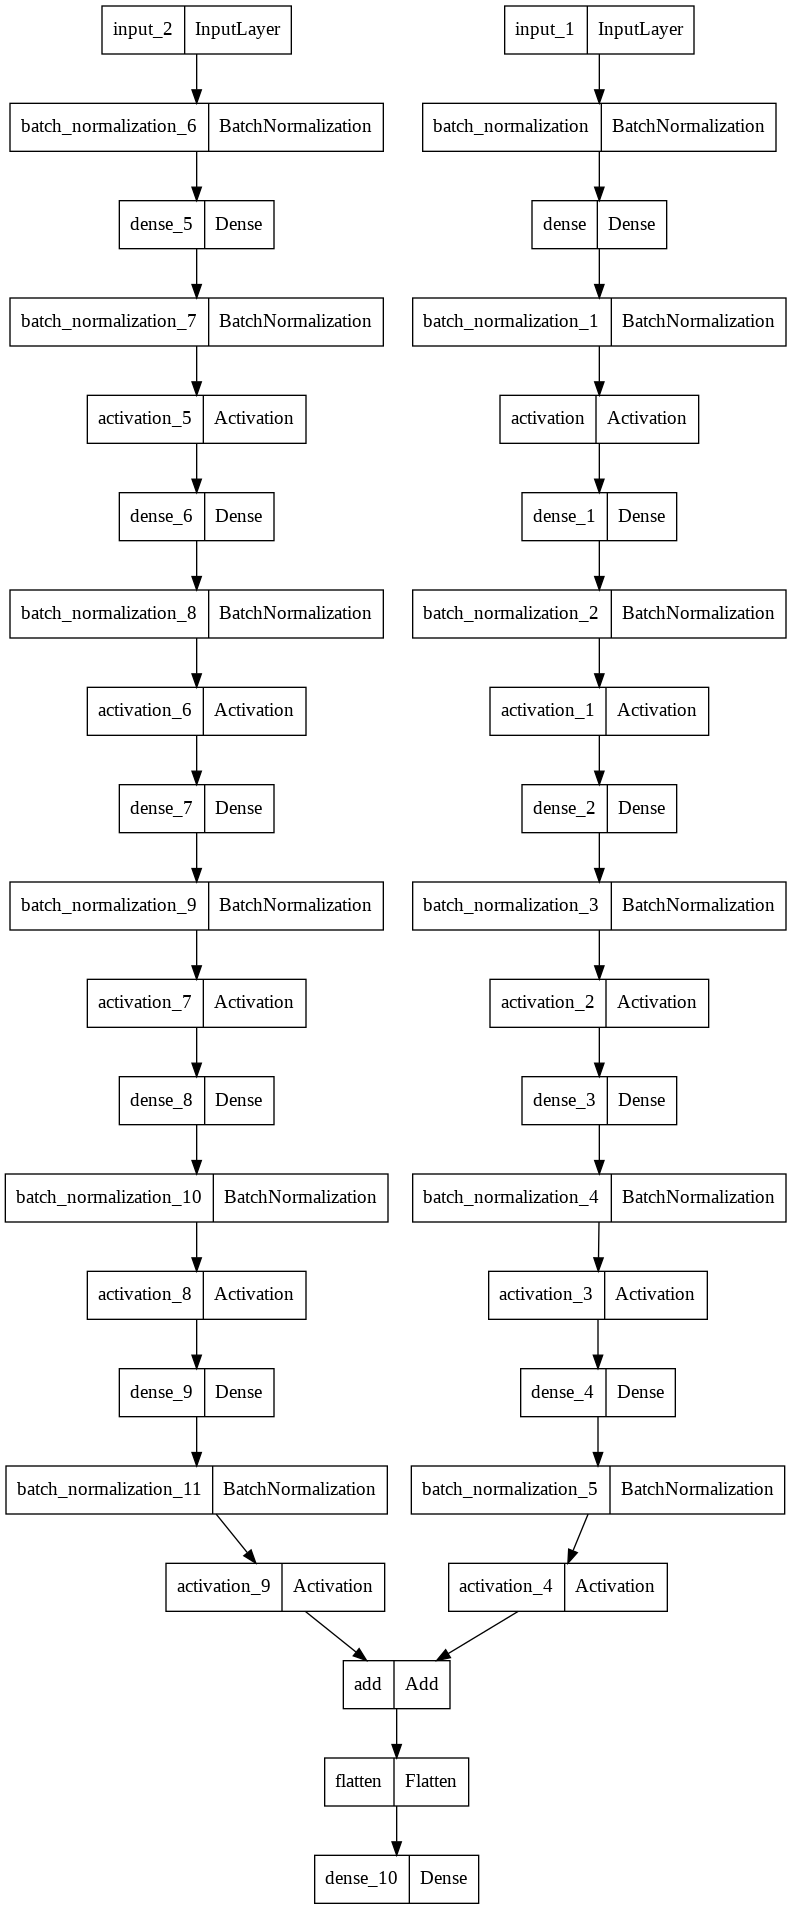

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(newModel, show_shapes=False, show_layer_names=True)

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
newModel.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=[f1_m])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("newModel.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "newModel", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = newModel.fit((X_train_A, X_train_B), y_train, validation_split=0.25, epochs=100, callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.8490 - f1_m: 0.3283

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


109/109 [==============================] - 35s 219ms/step - loss: 0.8490 - f1_m: 0.3283 - val_loss: 0.8185 - val_f1_m: 0.3483
Epoch 2/100
109/109 [==============================] - 17s 155ms/step - loss: 0.6490 - f1_m: 0.4726 - val_loss: 0.6974 - val_f1_m: 0.3658
Epoch 3/100
109/109 [==============================] - 17s 155ms/step - loss: 0.4913 - f1_m: 0.5965 - val_loss: 0.6432 - val_f1_m: 0.3739
Epoch 4/100
109/109 [==============================] - 17s 152ms/step - loss: 0.3864 - f1_m: 0.7196 - val_loss: 0.6372 - val_f1_m: 0.3874
Epoch 5/100
109/109 [==============================] - 16s 144ms/step - loss: 0.3018 - f1_m: 0.8281 - val_loss: 0.6716 - val_f1_m: 0.3958
Epoch 6/100
109/109 [==============================] - 15s 133ms/step - loss: 0.2409 - f1_m: 0.8883 - val_loss: 0.7410 - val_f1_m: 0.3974
Epoch 7/100
109/109 [==============================] - 15s 134ms/step - loss: 0.1920 - f1_m: 0.9421 - val_loss: 0.8214 - val_f1_m: 0.3825
Epoch 8/100
109/109 [=========================

In [ ]:
newModel = keras.models.load_model("newModel.h5", custom_objects=dependencies)
newModel.evaluate((X_test_A,X_test_B), y_test)

49/49 [==============================] - 2s 31ms/step - loss: 0.6276 - f1_m: 0.3723


[0.6276394724845886, 0.372304767370224]

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1188
           1       0.34      0.45      0.38       360

    accuracy                           0.66      1548
   macro avg       0.57      0.59      0.58      1548
weighted avg       0.70      0.66      0.68      1548

Logloss 11.580026886132904
****************************************************************************************************
Confusion matrix


[Text(0.5, 0, 'Predicted 0'), Text(1.5, 0, 'Predicted 1')]

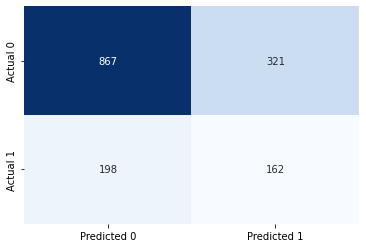

In [ ]:
y_pred = newModel.predict((X_test_A, X_test_B))
y_pred = (y_pred >= .5).astype(int)
print(classification_report(y_pred= y_pred, y_true= y_test))
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))
print('*' * 100)
print('Confusion matrix')     
cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
g = sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')
g.set_yticklabels(['Actual 0', 'Actual 1'])
g.set_xticklabels(['Predicted 0', 'Predicted 1'])